In [1]:
import os, sys
os.environ['ON_PY']="1"
from params import parser
from common_utils import setup_seed
from data_utils import pack_data_from_config
import numpy as np
from test_script.base import Test
import matplotlib.pyplot as plt
import numpy as np

notebook_dir = os.getcwd()
print(notebook_dir)
# 将工作目录更改为上一级目录
os.chdir("/home/wlc/FJSP-DRL-MAML")



(CVXPY) Apr 01 04:28:44 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 01 04:28:44 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


/home/wlc/miniconda3/envs/RL-torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wlc/miniconda3/envs/RL-torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


/home/wlc/FJSP-DRL-MAML/plot_imgs


In [2]:
instances = ["10x5x0+mix+EC", "20x5x0+mix+EC", "15x10x0+mix+EC", "20x10x0+mix+EC",]

plot_dict = {}
for key in instances:
    plot_dict[key] = [np.array(11) for _ in range(4)]

plot_dict

{'10x5x0+mix+EC': [array(11), array(11), array(11), array(11)],
 '20x5x0+mix+EC': [array(11), array(11), array(11), array(11)],
 '15x10x0+mix+EC': [array(11), array(11), array(11), array(11)],
 '20x10x0+mix+EC': [array(11), array(11), array(11), array(11)]}

In [3]:
# 数学解
a, b, *c = [1, 2]
c

[]

In [4]:


args = ["--test_data", "10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix",
        "--test_model", *instances]

ec_args = ["--fea_j_input_dim", "12", 
    "--fea_m_input_dim", "9",
    '--factor_Mk', "0.0",
    '--factor_Ec', "1.0", 
    "--model_source", "SD2EC",
    "--data_source", "SD2EC",]

args = [*ec_args, *args]

print(args)


['--fea_j_input_dim', '12', '--fea_m_input_dim', '9', '--factor_Mk', '0.0', '--factor_Ec', '1.0', '--model_source', 'SD2EC', '--data_source', 'SD2EC', '--test_data', '10x5+mix', '20x5+mix', '15x10+mix', '20x10+mix', '--test_model', '10x5x0+mix+EC', '20x5x0+mix+EC', '15x10x0+mix+EC', '20x10x0+mix+EC']


In [5]:
# DAN 解
configs = parser.parse_args(args=args)

setup_seed(configs.seed_test)


test_model = []

for model_name in configs.test_model:
    test_model.append((f'./trained_network/{configs.model_source}/{model_name}.pth', model_name))
print(test_model)
test_data = pack_data_from_config(configs.data_source, configs.test_data)

print(os.getcwd())
baseline_makespans = []
baseline_EC = []
for i in range(len(test_model)):
    model = test_model[i]
    data = test_data[i]
    print("datta[1]: ",data[1])
    print("-" * 25 + "Test Learned Model" + "-" * 25)
    print(f"test data name: {data[1]}")
    finetuning = True if model[1].startswith("maml") else False
    print(f"Model name : {model[1]}")
    result_5_times = []
    for j in range(2):
        test = Test(configs, data[0], model[0])
        result = test.greedy_strategy(finetuning=finetuning)
        result_5_times.append(result)
    result_5_times = np.array(result_5_times)

    save_result = np.mean(result_5_times, axis=0)
    print("testing results:")
    print(f"makespan(greedy): ", save_result[:, 0].mean())
    baseline_makespans.append(save_result[:, 0].mean())
    baseline_EC.append(save_result[:, 1].mean())
    # print(f"time: ", save_result[:, 2].mean())
    # print(f"Max fast_adapt cnt:", save_result[:, 2].max())
    # print(f"Average fast_adapt time:", save_result[:, 3].mean())
    print("="*100)

print(baseline_makespans)
print(baseline_EC)



[('./trained_network/SD2EC/10x5x0+mix+EC.pth', '10x5x0+mix+EC'), ('./trained_network/SD2EC/20x5x0+mix+EC.pth', '20x5x0+mix+EC'), ('./trained_network/SD2EC/15x10x0+mix+EC.pth', '15x10x0+mix+EC'), ('./trained_network/SD2EC/20x10x0+mix+EC.pth', '20x10x0+mix+EC')]
/home/wlc/FJSP-DRL-MAML
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : 10x5x0+mix+EC
testing results:
makespan(greedy):  819.3
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : 20x5x0+mix+EC
testing results:
makespan(greedy):  1356.9
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : 15x10x0+mix+EC
testing results:
makespan(greedy):  995.6
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name : 20x10x0+mix+EC
testing results:
m

In [6]:
# MAML finetuning
# 获取finetuning的每个过程

def MAML_finetuning_test(args):
    configs = parser.parse_args(args=args)
    # print(configs.hidden_dim_actor, configs.hidden_dim_critic)
    test_model = []
    for model_name in configs.test_model:
        test_model.append((f'./trained_network/{configs.model_source}/{model_name}.pth', model_name))
    print(test_model)

    model = test_model[0]

    test_data = pack_data_from_config(configs.data_source, configs.test_data)


    makespans = []
    finetuning_makespans = []
    finetuning_ecs = []
    for data in test_data:
        ### 对每个实例
        print("datta[1]: ",data[1])
        print("-" * 25 + "Test Learned Model" + "-" * 25)
        print(f"test data name: {data[1]}")
        if model[1].startswith("maml"): finetuning = True
        print(f"Model name : {model[1]}")
        result_5_times = []
        test = Test(configs, data[0], model[0])
        finetuning_makespan, finetuning_ec = test.finetuning()
        
        finetuning_makespans.append(finetuning_makespan)
        finetuning_ecs.append(finetuning_ec)

        # for j in range(2):
        #     result = test.greedy_strategy()
        #     result_5_times.append(result)
        # result_5_times = np.array(result_5_times)

        # save_result = np.mean(result_5_times, axis=0)
        # print("testing results:")
        # print(f"makespan(greedy): ", save_result[:, 0].mean())
        # makespans.append(save_result[:, 0].mean())
        # print(f"time: ", save_result[:, 1].mean())
        # # print(f"Max fast_adapt cnt:", save_result[:, 2].max())
        # # print(f"Average fast_adapt time:", save_result[:, 3].mean())
        # print("="*100)

    return finetuning_makespans, finetuning_ecs



In [7]:
model = "maml+exp18-9"
# model = "maml+exp18-10"
# model = "maml+EXP19maml1707148858" #调整为竞争的工件和机器
# model = "maml+EXP19maml1707189752" #调整训练次数1->4
# model = "maml+EXP19maml1707277364" #只用MAML训练actor
# model = "maml+EXP19maml1708610726" # 内部更新feature_exact
# model = "maml+EXP19maml1709199921" # 缓更新
# model = "maml+EXP19maml1709210851" # adapt_lr=0.01
# model = "maml+EXP19maml1709211969" # adapt_lr=0.001
# model = "maml+EXP19maml1709212192" ## adapt_lr=0.0001
model = "maml+EXP19maml1709367712" # 无缓更新技术
model = "maml+EXP19maml1709693698"  ## feature_exact
model = "maml+EXP19maml1709779578"  # iter 500 + op_per_job=10
model = "maml+EXP19maml1709779197"  # iter = 500 op_per_job=M
model = "maml+EXP19maml1709816607"  ### 缓更新  iter=400
# model = "maml+EXP19maml1710490407"
model = "maml+MAMLECmaml1711335786"
model = "maml+MAMLECmaml1711939372"
args = [*ec_args, "--test_data", "10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix", 
        "--hidden_dim_actor", "512", "--hidden_dim_critic", "512",
        "--test_model", model, 
        ]

maml_finetuning_makespans, maml_finetuning_ecs = MAML_finetuning_test(args)

print(maml_finetuning_makespans)


[('./trained_network/SD2EC/maml+MAMLECmaml1711939372.pth', 'maml+MAMLECmaml1711939372')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : maml+MAMLECmaml1711939372
datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : maml+MAMLECmaml1711939372
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : maml+MAMLECmaml1711939372
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name : maml+MAMLECmaml1711939372
[array([799.2, 818.8, 858.7, 816.2, 823.1, 821.7, 840.2, 783.7, 817.6,
       800.6, 807.2]), array([1549.1, 1586.7, 1515.7, 1617.6, 1546.7, 1591.1, 1581.7, 1606.5,
       1574.3, 1570.2, 1545.4]), array([1133.6, 1201.9, 1117.7, 1156.4, 1120.6, 1093.7, 1172.3, 1094.9,
       1141.4, 1111.2, 107

In [8]:
# pretrain finetuning

args = [*ec_args, "--test_data", "10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix", 
        "--hidden_dim_actor", "512", "--hidden_dim_critic", "512",
        "--test_model", "maml+MAMLECpre_train1711621186"]

pretrain_finetuning_makespans, pretrain_finetuning_ecs = MAML_finetuning_test(args)


print(plot_dict)

[('./trained_network/SD2EC/maml+MAMLECpre_train1711621186.pth', 'maml+MAMLECpre_train1711621186')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : maml+MAMLECpre_train1711621186


datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : maml+MAMLECpre_train1711621186
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : maml+MAMLECpre_train1711621186
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name : maml+MAMLECpre_train1711621186
{'10x5x0+mix+EC': [array(11), array(11), array(11), array(11)], '20x5x0+mix+EC': [array(11), array(11), array(11), array(11)], '15x10x0+mix+EC': [array(11), array(11), array(11), array(11)], '20x10x0+mix+EC': [array(11), array(11), array(11), array(11)]}


In [9]:
# random
import torch
from model.PPO import PPO_initialize

ppo = PPO_initialize(configs)

torch.save(ppo.policy.state_dict(), f'./trained_network/SD2EC/test_random.pth')

args = [*ec_args, "--test_data", "10x5+mix", "20x5+mix", "15x10+mix", "20x10+mix", 
        "--test_model", "test_random"]

random_finetuning_makespans, random_finetuning_ecs = MAML_finetuning_test(args)



[('./trained_network/SD2EC/test_random.pth', 'test_random')]
datta[1]:  10x5+mix
-------------------------Test Learned Model-------------------------
test data name: 10x5+mix
Model name : test_random


datta[1]:  20x5+mix
-------------------------Test Learned Model-------------------------
test data name: 20x5+mix
Model name : test_random
datta[1]:  15x10+mix
-------------------------Test Learned Model-------------------------
test data name: 15x10+mix
Model name : test_random
datta[1]:  20x10+mix
-------------------------Test Learned Model-------------------------
test data name: 20x10+mix
Model name : test_random


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for the 2D array (4 rows, 11 columns)

def plot_makespan(data, title, labels = ["DAN_baseline", "MAML", "pre_training", "random"], x_label="Meta Iteration", y_label="Makespan"):
    # Labels for the lines
    labels = ["DAN_baseline", "MAML", "pre_training", "random"]

    # Plotting the lines
    for i, row in enumerate(data):
        plt.plot(row, label=labels[i])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()


{'10x5x0+mix+EC': [array([819.3, 819.3, 819.3, 819.3, 819.3, 819.3, 819.3, 819.3, 819.3,
       819.3, 819.3]), array([799.2, 818.8, 858.7, 816.2, 823.1, 821.7, 840.2, 783.7, 817.6,
       800.6, 807.2]), array([756.2, 726. , 720.3, 729.3, 711. , 714.9, 740.2, 715.7, 753.1,
       696.4, 747.2]), array([794.1, 825.6, 762.1, 774.5, 743.5, 799.4, 812.9, 777.8, 767.3,
       789.3, 767.4])], '20x5x0+mix+EC': [array([1356.9, 1356.9, 1356.9, 1356.9, 1356.9, 1356.9, 1356.9, 1356.9,
       1356.9, 1356.9, 1356.9]), array([1549.1, 1586.7, 1515.7, 1617.6, 1546.7, 1591.1, 1581.7, 1606.5,
       1574.3, 1570.2, 1545.4]), array([1459.2, 1420.9, 1432.4, 1470. , 1427.6, 1469.5, 1456.6, 1398.5,
       1416.5, 1446.6, 1433.6]), array([1543.1, 1521.9, 1482.9, 1491.3, 1508.5, 1528.2, 1473.7, 1499.4,
       1491.5, 1533.2, 1478. ])], '15x10x0+mix+EC': [array([995.6, 995.6, 995.6, 995.6, 995.6, 995.6, 995.6, 995.6, 995.6,
       995.6, 995.6]), array([1133.6, 1201.9, 1117.7, 1156.4, 1120.6, 1093.7, 1172.3

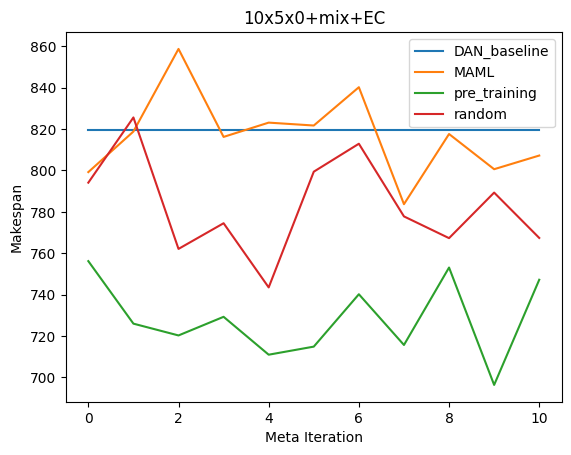

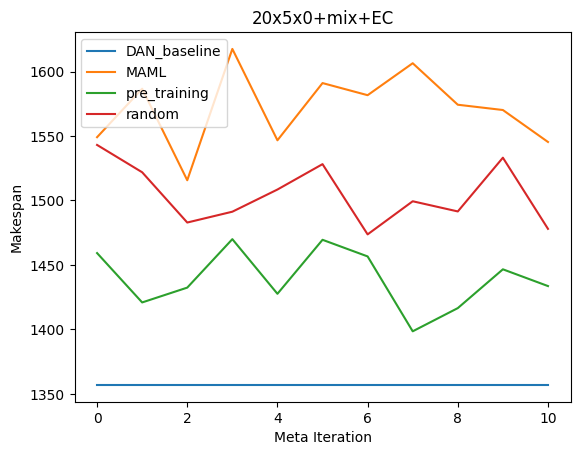

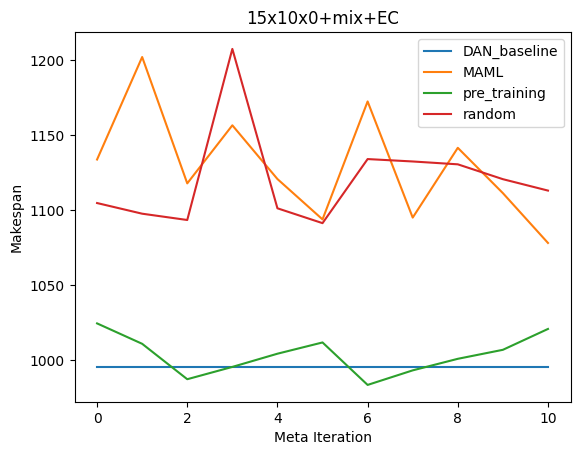

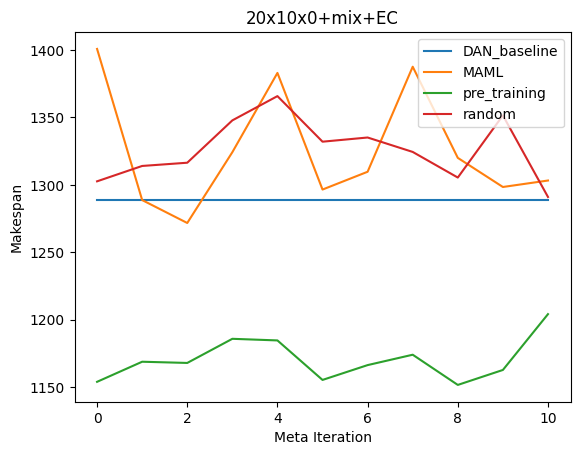

In [18]:

for idx, key in enumerate(instances):
    # plot_dict[key][0] = [baseline_makespans[idx]  for _ in range(configs.adapt_nums)]
    plot_dict[key][0] = np.full(configs.adapt_nums, baseline_makespans[idx])
    plot_dict[key][1] = maml_finetuning_makespans[idx]
    plot_dict[key][2] = pretrain_finetuning_makespans[idx]
    plot_dict[key][3] = random_finetuning_makespans[idx]

print(plot_dict)

for key in instances:
    data = plot_dict[key]
    plot_makespan(data, key)

{'10x5x0+mix+EC': [array([10.99355125, 10.99355125, 10.99355125, 10.99355125, 10.99355125,
       10.99355125, 10.99355125, 10.99355125, 10.99355125, 10.99355125,
       10.99355125]), array([11.2458538 , 11.19825144, 10.96711214, 10.99210432, 11.02193221,
       11.10670871, 11.00103612, 11.22468119, 10.91142748, 11.12254588,
       11.40647315]), array([11.42025535, 11.2810864 , 11.50427991, 11.23771773, 11.17274531,
       11.38522615, 11.36860893, 11.32251353, 11.15742301, 11.40977952,
       11.22986941]), array([11.21331117, 11.22142533, 11.56197108, 11.33683868, 11.50947197,
       11.16929266, 11.32550426, 11.38581558, 11.36980382, 11.29735121,
       11.42775608])], '20x5x0+mix+EC': [array([23.91499058, 23.91499058, 23.91499058, 23.91499058, 23.91499058,
       23.91499058, 23.91499058, 23.91499058, 23.91499058, 23.91499058,
       23.91499058]), array([24.47552259, 24.2793695 , 24.21045073, 23.69948807, 24.24933705,
       24.05670937, 23.96893255, 23.99559487, 24.14916435, 2

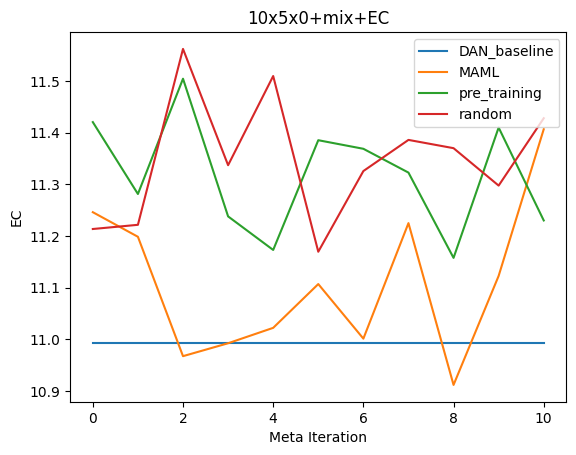

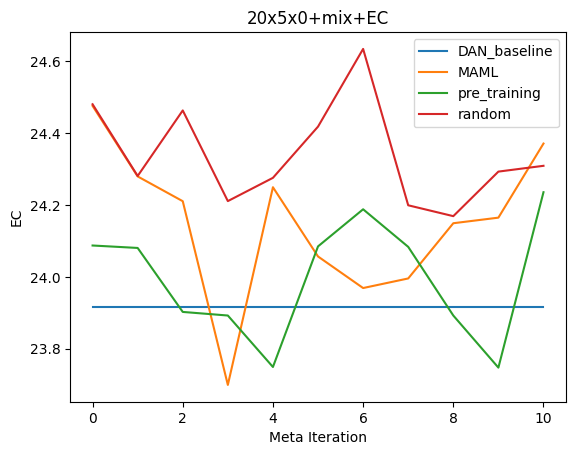

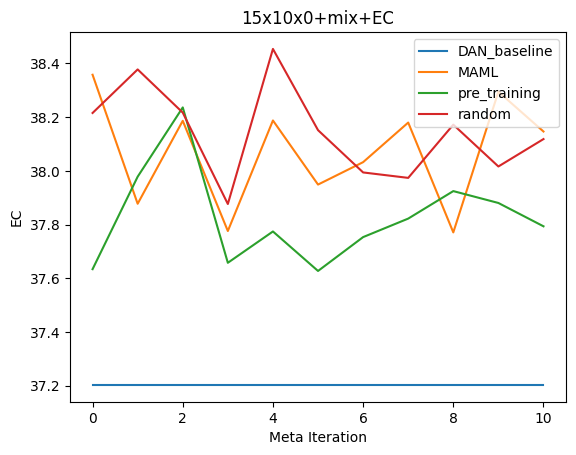

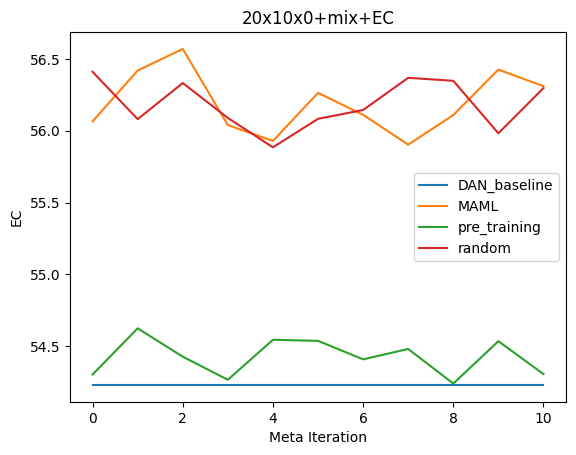

In [19]:

for idx, key in enumerate(instances):
    # plot_dict[key][0] = [baseline_makespans[idx]  for _ in range(configs.adapt_nums)]
    plot_dict[key][0] = np.full(configs.adapt_nums, baseline_EC[idx])
    plot_dict[key][1] = maml_finetuning_ecs[idx]
    plot_dict[key][2] = pretrain_finetuning_ecs[idx]
    plot_dict[key][3] = random_finetuning_ecs[idx]

print(plot_dict)

for key in instances:
    data = plot_dict[key]
    plot_makespan(data, key, x_label="Meta Iteration", y_label="EC")

In [13]:
pretrain_finetuning_ecs

[array([11.42025535, 11.2810864 , 11.50427991, 11.23771773, 11.17274531,
        11.38522615, 11.36860893, 11.32251353, 11.15742301, 11.40977952,
        11.22986941]),
 array([24.08723542, 24.08043459, 23.90250139, 23.89249612, 23.74938795,
        24.0848125 , 24.18796512, 24.0834503 , 23.89250653, 23.74760325,
        24.2354529 ]),
 array([37.63365086, 37.97815858, 38.23620716, 37.65740355, 37.77408612,
        37.62696902, 37.75311191, 37.82204784, 37.92448596, 37.88024174,
        37.79333088]),
 array([54.30219856, 54.62374404, 54.42635718, 54.2655241 , 54.54401882,
        54.53634292, 54.40783827, 54.47990539, 54.23879335, 54.53428025,
        54.30515983])]